In [ ]:
# =============================================== usuals
import pandas as pd
import numpy as np

# =============================================== plot
import seaborn as sns
import matplotlib.pyplot as plt
# ============================================== Images
# =============================================== web scraping
import requests
import zipfile

from io import StringIO
from io import  BytesIO

from requests_html import HTMLSession 
from requests_html import AsyncHTMLSession
from datetime import datetime


from time import sleep
from tqdm import tqdm

# ================================================ warnings
import warnings
warnings.filterwarnings('ignore')

: 

In [2]:
path = 'C:/Users/lucap/Downloads/Turbidez/Turbidez'

# **Functions**

> **Web scraping**

In [3]:
# Web scraping



def weather_series(station,years):
        session = HTMLSession() # Inicializa a classe de Requisicoes HTML
        url = 'https://portal.inmet.gov.br/dadoshistoricos'
        r = session.get(url) # Obtem as requisicoes

        # Pega todos os links de download dos arquivos com os dados climaticos historicos.
        links = [i for i in r.html.find('a') if 'https://portal.inmet.gov.br/uploads/dadoshistoricos' in str(i)]
        # <a href="https://portal.inmet.gov.br/uploads/dadoshistoricos/2001.zip">ANO 2001 (AUTOMÁTICA)</a>

        out = pd.DataFrame()
        for station in station:
            # Bloco que captura e trata os dados presentes em cada link obtido.
                for y in years:

                    url = list(filter(lambda x: str(y) in x.attrs['href'],links))[0].attrs['href'] 
                    a = BytesIO(requests.get(url).content)
                    mzip = zipfile.ZipFile(a)
                    FILE_NAME = [i.filename for i in mzip.infolist() if station in i.filename] # A001 - ESTAÇÃO DE BRASILIA
                    bytes_arq = mzip.open(name = FILE_NAME[0], mode = 'r').read()
                    string_arq = str(bytes_arq,'latin-1')
                    data = StringIO(string_arq) 
                    df_clim=pd.read_csv(data,skiprows = range(0, 8), error_bad_lines=False, encoding='latin-1',sep=';')
                    df_clim = df_clim.loc[:,~df_clim.columns.str.match("Unnamed")]


                    df_clim['Hora UTC'] = df_clim['Hora UTC'].apply(lambda x: x.replace('00 UTC',''))
                    df_clim['index'] = df_clim['Data'].astype(str)+' '+df_clim['Hora UTC'].astype(str)
                    df_clim['index'] = df_clim['index'].apply(lambda x: datetime.strptime(x,'%Y/%m/%d %H'))
                    df_clim.set_index('index',inplace=True)
                    df_clim.drop(['Data','Hora UTC'],axis=1,inplace=True)
                    df_clim = df_clim.apply(lambda x: x.apply(lambda y: str(y).replace(',','.'))) #trocar todas as virgulas por pontos
                    df_clim = df_clim.astype(float)
                
                    df_clim['CÓDIGO_ESTAÇÃO'] = station
                    out = pd.concat([out,df_clim],axis=0,ignore_index=False)
                

        New_Names=['precipitacao',
                   'pressao_instantanea',
                   'pressao_max',
                   'pressao_min',
                   'radiacao',
                   'temperatura_bulbo_seco',
                   'temperatura_orvalho_instantanea',
                   'temperatura_maxima',
                   'temperatura_minima',
                   'temperatura_maxima_orvalho',
                   'temperatura_minima_orvalho',
                   'umidade_relativa_maxima',
                   'umidade_relativa_minima',
                   'umidade_relativa_instantanea',
                    'vento_direcao', 
                    'vento_rajada',
                    'vento_velocidade', 
                    'estacao',
                    'radiacao']

        out.columns = New_Names
        return out   

> **Plots**

In [4]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=8.5):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize,fontweight='bold')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize,fontweight='bold')
    # axes.set_ylabel('True label',fontsize=fontsize)
    # axes.set_xlabel('Predicted label',fontsize=fontsize)
    axes.set_title(f"{class_label}",fontsize=fontsize,fontweight='bold')

> **Images**

In [5]:
def get_concat_h_repeat(im, column):
    dst = Image.new('RGB', (im.width * column, im.height))
    for x in range(column):
        dst.paste(im, (x * im.width, 0))
    return dst

def get_concat_v_repeat(im, row):
    dst = Image.new('RGB', (im.width, im.height * row))
    for y in range(row):
        dst.paste(im, (0, y * im.height))
    return dst

def get_concat_tile_repeat(im, row, column):
    dst_h = get_concat_h_repeat(im, column)
    return get_concat_v_repeat(dst_h, row)

# **Extraction**

In [6]:
years = [2019,2020,2021,2022]
stations = ['A047']
df_inmet = weather_series(stations,years)
df_inmet.head(3)

,precipitacao,pressao_instantanea,pressao_max,pressao_min,radiacao,temperatura_bulbo_seco,temperatura_orvalho_instantanea,temperatura_maxima,temperatura_minima,temperatura_maxima_orvalho,temperatura_minima_orvalho,umidade_relativa_maxima,umidade_relativa_minima,umidade_relativa_instantanea,vento_direcao,vento_rajada,vento_velocidade,estacao,radiacao
index,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,0.8,899.2,899.2,898.6,NaN,19.3,18.1,19.4,19.2,18.4,18.0,94.0,92.0,93.0,344.0,3.7,1.6,A047,NaN
2019-01-01 01:00:00,1.8,900.0,900.0,899.2,NaN,19.1,18.2,19.3,19.1,18.3,18.0,95.0,92.0,94.0,275.0,3.4,0.9,A047,NaN
2019-01-01 02:00:00,0.0,900.3,900.4,900.0,NaN,18.9,18.4,19.2,18.8,18.5,18.1,97.0,94.0,97.0,237.0,2.2,0.4,A047,NaN


In [7]:
df_vz = pd.read_csv(path+'/rde.csv',parse_dates=['index'])
df_vz.head(3)

,index,AAB.RDE.030.FIT.001.000.000,AAB.RDE.050.FIT.001.000.000,EAB.RDE.001.CMB.001.RUN.000,EAB.RDE.001.CMB.002.RUN.000,EAB.RDE.001.CMB.003.RUN.000,EAB.RDE.001.CMB.004.RUN.000,EAB.RDE.001.CMB.005.RUN.000
0,2019-01-01 00:00:00,1920.617820,1934.765541,0.0,1.0,0.0,0.0,1.0
1,2019-01-01 01:00:00,1924.652125,1939.693707,0.0,0.0,0.0,1.0,1.0
2,2019-01-01 02:00:00,1923.320710,1938.880453,0.0,0.0,0.0,1.0,1.0


In [8]:
df = df_vz.set_index('index').join(df_inmet)
df.head(3)

,AAB.RDE.030.FIT.001.000.000,AAB.RDE.050.FIT.001.000.000,EAB.RDE.001.CMB.001.RUN.000,EAB.RDE.001.CMB.002.RUN.000,EAB.RDE.001.CMB.003.RUN.000,EAB.RDE.001.CMB.004.RUN.000,EAB.RDE.001.CMB.005.RUN.000,precipitacao,pressao_instantanea,pressao_max,...,temperatura_maxima_orvalho,temperatura_minima_orvalho,umidade_relativa_maxima,umidade_relativa_minima,umidade_relativa_instantanea,vento_direcao,vento_rajada,vento_velocidade,estacao,radiacao
index,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,1920.617820,1934.765541,0.0,1.0,0.0,0.0,1.0,0.8,899.2,899.2,...,18.4,18.0,94.0,92.0,93.0,344.0,3.7,1.6,A047,NaN
2019-01-01 01:00:00,1924.652125,1939.693707,0.0,0.0,0.0,1.0,1.0,1.8,900.0,900.0,...,18.3,18.0,95.0,92.0,94.0,275.0,3.4,0.9,A047,NaN
2019-01-01 02:00:00,1923.320710,1938.880453,0.0,0.0,0.0,1.0,1.0,0.0,900.3,900.4,...,18.5,18.1,97.0,94.0,97.0,237.0,2.2,0.4,A047,NaN


# **Understend data**

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28262 entries, 2019-01-01 00:00:00 to 2022-03-23 09:00:00
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   AAB.RDE.030.FIT.001.000.000      28262 non-null  float64
 1   AAB.RDE.050.FIT.001.000.000      28262 non-null  float64
 2   EAB.RDE.001.CMB.001.RUN.000      28261 non-null  float64
 3   EAB.RDE.001.CMB.002.RUN.000      27949 non-null  float64
 4   EAB.RDE.001.CMB.003.RUN.000      27950 non-null  float64
 5   EAB.RDE.001.CMB.004.RUN.000      28260 non-null  float64
 6   EAB.RDE.001.CMB.005.RUN.000      28051 non-null  float64
 7   precipitacao                     27748 non-null  float64
 8   pressao_instantanea              27749 non-null  float64
 9   pressao_max                      27739 non-null  float64
 10  pressao_min                      27739 non-null  float64
 11  radiacao                         4676 non-nul

In [10]:
nulos_p = (df.isna().sum()/len(df))*100
nulos_p = pd.DataFrame(nulos_p,columns=['Nulos (%)'])
nulos_p.reset_index().style.background_gradient(cmap='coolwarm')


,index,Nulos (%)
0,AAB.RDE.030.FIT.001.000.000,0.000000
1,AAB.RDE.050.FIT.001.000.000,0.000000
2,EAB.RDE.001.CMB.001.RUN.000,0.003538
3,EAB.RDE.001.CMB.002.RUN.000,1.107494
4,EAB.RDE.001.CMB.003.RUN.000,1.103956
5,EAB.RDE.001.CMB.004.RUN.000,0.007077
6,EAB.RDE.001.CMB.005.RUN.000,0.746586
7,precipitacao,1.818696
8,pressao_instantanea,1.815158
9,pressao_max,1.850541


In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
AAB.RDE.030.FIT.001.000.000,28262.0,1949.098548,510.428774,0.000000,1895.074207,1931.410652,2363.832136,2814.867029
AAB.RDE.050.FIT.001.000.000,28262.0,1902.280879,530.176039,-76.440532,1833.290760,1912.622186,2319.137946,2841.926215
EAB.RDE.001.CMB.001.RUN.000,28261.0,0.432235,0.489194,0.000000,0.000000,0.000000,1.000000,1.000000
EAB.RDE.001.CMB.002.RUN.000,27949.0,0.512215,0.484975,0.000000,0.000000,0.683333,1.000000,1.000000
EAB.RDE.001.CMB.003.RUN.000,27950.0,0.013263,0.112609,0.000000,0.000000,0.000000,0.000000,1.000000
EAB.RDE.001.CMB.004.RUN.000,28260.0,0.550606,0.482187,0.000000,0.000000,1.000000,1.000000,1.000000
EAB.RDE.001.CMB.005.RUN.000,28051.0,0.615872,0.481593,0.000000,0.000000,1.000000,1.000000,1.000000
precipitacao,27748.0,0.195956,1.701481,0.000000,0.000000,0.000000,0.000000,70.200000
pressao_instantanea,27749.0,899.411557,2.600599,891.100000,897.600000,899.300000,901.100000,908.900000
pressao_max,27739.0,899.664292,2.575628,891.100000,897.900000,899.500000,901.300000,909.000000


# **EDS**

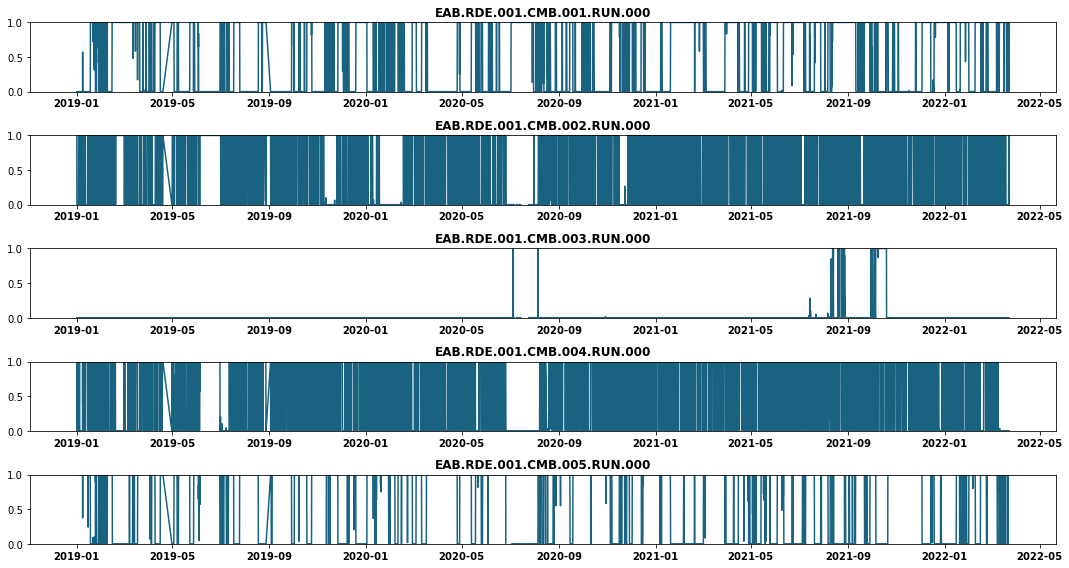

In [12]:
fig,_= plt.subplots(figsize=(15,8))

for i,c in enumerate(df.columns[df.columns.str.contains('.CMB.')],1):

  x = df.index
  y = df[c].values
  plt.subplot(5,1,i)
  plt.plot(x,y,color='#196381')
  plt.title(c,fontweight='bold')
  plt.xticks(fontweight='bold')
  plt.ylim([0,1])
fig.tight_layout()
plt.show()

In [13]:
for i in df.columns[df.columns.str.contains('CMB')]:
  classes = pd.DataFrame(df.loc[:,i].value_counts())
  bin_target = classes[(classes.index==1) | (classes.index==0)]
  print(bin_target)
  percent = (bin_target.sum().values[0]/len(df))*100
  display(f'Total:{round(percent,2)}%')

     EAB.RDE.001.CMB.001.RUN.000
0.0                        15573
1.0                        11673


'Total:96.41%'

     EAB.RDE.001.CMB.002.RUN.000
1.0                        13049
0.0                        12601


'Total:90.76%'

     EAB.RDE.001.CMB.003.RUN.000
0.0                        27537
1.0                          342


'Total:98.64%'

     EAB.RDE.001.CMB.004.RUN.000
1.0                        14263
0.0                        11667


'Total:91.75%'

     EAB.RDE.001.CMB.005.RUN.000
1.0                        16879
0.0                        10394


'Total:96.5%'

In [14]:
targets_p=pd.DataFrame()
for i in df.columns[df.columns.str.contains('CMB')]:
    classes = round(df.loc[:,i],1)
    targets = classes.value_counts()
    percent = (targets/targets.sum())*100
    targets_p = pd.concat([targets_p,percent],axis=1)
display(targets_p.style.background_gradient(cmap='coolwarm'))

,EAB.RDE.001.CMB.001.RUN.000,EAB.RDE.001.CMB.002.RUN.000,EAB.RDE.001.CMB.003.RUN.000,EAB.RDE.001.CMB.004.RUN.000,EAB.RDE.001.CMB.005.RUN.000
0.000000,55.256360,45.425597,98.561717,41.564048,37.228619
1.000000,41.491808,47.028516,1.227191,50.792640,60.318705
0.800000,0.544921,1.223657,0.025045,1.323425,0.335104
0.700000,0.445844,1.531361,0.021467,1.528662,0.320844
0.600000,0.396306,1.051916,0.014311,1.167728,0.317279
0.400000,0.321999,0.651186,0.035778,0.668790,0.238851
0.200000,0.318460,0.622563,0.014311,0.605096,0.249545
0.500000,0.314922,0.855129,0.028623,0.831564,0.285195
0.900000,0.307845,0.540270,0.014311,0.470630,0.224591
0.100000,0.300768,0.522380,0.032200,0.523708,0.235286


# **Preprossessing**

In [15]:
df.drop(['radiacao'],axis=1,inplace=True)
df.drop(['estacao'],axis=1,inplace=True)
df.drop(['EAB.RDE.001.CMB.003.RUN.000'],axis=1,inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)

# **Feature selection**

> **Tukey method**

In [16]:
from statsmodels.stats.multicomp import MultiComparison
tuky_classes = df.loc[:,df.columns.str.contains('CMB')].apply(lambda med: med.apply(lambda x: 1 if x>0.3 else 0))
results_tukey = pd.DataFrame()
for i in df.columns[df.columns.str.contains('CMB')]:
    aux = pd.DataFrame()
    for l in df.columns[~df.columns.str.contains('CMB')]:
    
        mc = MultiComparison(df[l],tuky_classes[i])
        mc_results = mc.tukeyhsd()
        aux = aux.append(pd.DataFrame([[round(mc_results.pvalues[0],4),mc_results.reject[0]]], columns = [(i,'pvalues'),(i,'reject')],index=[l]))

    results_tukey = pd.concat([results_tukey,aux],axis=1)
    
results_tukey.columns = pd.MultiIndex.from_tuples(results_tukey.columns, names=['Medidor','Statistics'])

In [17]:
results_tukey.style.background_gradient(cmap='coolwarm')

# **Split data**

In [18]:
dt = df.copy()
y_dt = dt[df.columns[df.columns.str.contains('.CMB.')]]
x_dt = dt[df.columns[~df.columns.str.contains('.CMB.')]]

# **ML model**

## **Classification**

In [24]:
# ======================================================= Models
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from xgboost import XGBRFClassifier
from lightgbm import LGBMClassifier
from sklearn.multiclass import OneVsRestClassifier
# ======================================================= Select feature
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFE
# ======================================================= Pipeline
from sklearn.pipeline import Pipeline 
# ======================================================= Cross validation
from sklearn.model_selection import StratifiedKFold
# ======================================================= Metrics
from sklearn.metrics import accuracy_score,mean_absolute_error,mean_squared_error,multilabel_confusion_matrix,recall_score,precision_score,f1_score,log_loss,classification_report,hamming_loss
# =======================================================
from sklearn.model_selection import train_test_split

ImportError: cannot import name 'XGBClassifier' from 'xgboost' (unknown location)

In [ ]:
# https://github.com/catboost/tutorials/blob/94e3bc9c3510ed69c2da7f544ec8979387419ec9/classification/multilabel_classification_tutorial.ipynb

> **Pipeline**

In [ ]:
# MODELS
ctbml    = CatBoostClassifier(loss_function='MultiLogloss',eval_metric='HammingLoss',iterations=500,verbose=0)
cbc_ovr  = OneVsRestClassifier(CatBoostClassifier(verbose=0,auto_class_weights = 'Balanced',loss_function='Logloss'))
xgb_prox = XGBClassifier(tree_method="approx")
xgb_hist = XGBClassifier(tree_method="hist")
lgbm     = OneVsRestClassifier(LGBMClassifier(is_unbalance=True))

NameError: name 'CatBoostClassifier' is not defined

In [ ]:
aasds

NameError: name 'aasds' is not defined

In [ ]:
feature_selection = {
                     'XGB_conf_hist' : RFE(xgb_hist),

                     'XGB_conf_aprox' : RFE(xgb_prox),

                     'LGBM_OVR' : RFE(lgbm),    

                     'CTB_ML' : RFE(ctbml),
                                                
                     'CTB_OVR' : RFE(cbc_ovr)
                    }

In [ ]:
for k in feature_selection.keys():
    print(k)
    feature_selection[k].fit(x_dt,y_dt)

XGB_conf_hist


ValueError: y should be a 1d array, got an array of shape (26482, 4) instead.

In [ ]:
# Models
ml_models_classifier = {
                        'XGB_conf_hist' : xgb_hist,

                        'XGB_conf_aprox' : xgb_prox,

                        'LGBM_OVR' : lgbm,    
    
                        'CTB_ML' : ctbml,
                                                 
                        'CTB_OVR' : cbc_ovr
                        
                       }

> **Cross validation**

In [ ]:
def make_df_confusion_matrix(cm,model_name):
    results = pd.DataFrame()
    for i in range(cm.shape[0]):
        col = [(model_name,i,1),(model_name,i,0)]
        idx = ['1','0']
        df = pd.DataFrame(cm[i],columns=col,index=idx)
        df.columns = pd.MultiIndex.from_tuples(df.columns)
        results = pd.concat([results,df],axis=1)
    return results

In [ ]:
y_dt_cls = y_dt.apply(lambda c: c.apply(lambda x: 1 if x>0.3 else 0))
y_stratify = [''.join(v) for i,v in y_dt_cls.astype(str).iterrows()]

# CROSS VALIDATION - BEST MODEL
skf = StratifiedKFold(n_splits=3, random_state=43,shuffle=True)


results_cv = pd.DataFrame()
confusion_matrix_cv = pd.DataFrame()
for model_name in tqdm(ml_models_classifier.keys()):
  sleep(0.001)
  confusion_mtx_model = pd.DataFrame()
  for cv,(train_index, test_index) in enumerate(skf.split(x_dt,y_stratify),1):
      # ============================ split data ===================================
      X_train, y_train = x_dt.iloc[train_index],y_dt_cls.iloc[train_index]
      X_test, y_test = x_dt.iloc[test_index],y_dt_cls.iloc[test_index]

      # ============================ train model ===================================
      ml_models_classifier[model_name].fit(X_train, y_train)

      # ============================ predict model ===================================
      y_hat = ml_models_classifier[model_name].predict(X_test)

      # ============================ confusion matrix ===================================
      cm = multilabel_confusion_matrix(y_test, y_hat)
      df_cm = make_df_confusion_matrix(cm,model_name)
      confusion_mtx_model = confusion_mtx_model.append(df_cm) 
      
      # ============================ classifier reports ===================================
      c_report = classification_report(y_test, y_hat,output_dict=True)
      c_report['model'] = model_name
      c_report['CV'] = cv

      results_cv = results_cv.append(pd.DataFrame(c_report))
  confusion_matrix_cv = pd.concat([confusion_matrix_cv,confusion_mtx_model],axis=1)
# SAVE RESULTS  
confusion_matrix_cv.to_csv(path+'/CrossValidate/Motor/confusion_matrix/confusion_matrix_motors.txt', header=True, index=True, sep=',', mode='w')
results_cv.to_csv(path+'/CrossValidate/Motor/reports/cross_validation_motors.txt', header=True, index=True, sep=',', mode='w')

### **Results**

In [ ]:
# Results
results = pd.read_csv(path+'/CrossValidate/Motor/reports/cross_validation_motors.txt',index_col=[0])
results = results_cv.copy()
for i in results.index.unique()[0:3]:
  display(results[results.index==i])

,0,1,2,3,micro avg,macro avg,weighted avg,samples avg,model,CV
precision,0.849655,0.856683,0.841055,0.917816,0.868150,0.866302,0.868660,0.857971,XGB_conf_hist,1
precision,0.854621,0.854530,0.838657,0.915574,0.867485,0.865845,0.867845,0.859258,XGB_conf_hist,2
precision,0.849336,0.853982,0.843051,0.914265,0.867043,0.865159,0.867447,0.860938,XGB_conf_hist,3
precision,0.844298,0.859705,0.846013,0.918371,0.869321,0.867097,0.869809,0.858726,XGB_conf_aprox,1
precision,0.856509,0.861410,0.842462,0.916084,0.870768,0.869116,0.871073,0.861542,XGB_conf_aprox,2
precision,0.854391,0.854101,0.839789,0.918190,0.868131,0.866618,0.868747,0.862137,XGB_conf_aprox,3
precision,0.801382,0.870484,0.853325,0.934740,0.867432,0.864983,0.870491,0.850164,LGBM_OVR,1
precision,0.805823,0.862597,0.844153,0.931779,0.863725,0.861088,0.866151,0.846314,LGBM_OVR,2
precision,0.813140,0.859614,0.857254,0.939027,0.870113,0.867259,0.872465,0.854518,LGBM_OVR,3
precision,0.836382,0.857018,0.830791,0.908681,0.860019,0.858218,0.860716,0.849154,CTB_ML,1


,0,1,2,3,micro avg,macro avg,weighted avg,samples avg,model,CV
recall,0.862221,0.847951,0.896370,0.917316,0.883658,0.880965,0.883658,0.864078,XGB_conf_hist,1
recall,0.854399,0.843458,0.896935,0.924374,0.883165,0.879792,0.883165,0.863600,XGB_conf_hist,2
recall,0.862999,0.860692,0.897346,0.920399,0.888085,0.885359,0.888085,0.867613,XGB_conf_hist,3
recall,0.862481,0.854959,0.902810,0.920036,0.887928,0.885071,0.887928,0.867713,XGB_conf_aprox,1
recall,0.852063,0.851529,0.897716,0.926551,0.885509,0.881965,0.885509,0.865885,XGB_conf_aprox,2
recall,0.863259,0.868974,0.901249,0.919855,0.891053,0.888334,0.891053,0.871068,XGB_conf_aprox,3
recall,0.902439,0.813549,0.841335,0.867452,0.854286,0.856194,0.854286,0.831691,LGBM_OVR,1
recall,0.890734,0.801402,0.855358,0.876859,0.855402,0.856088,0.855402,0.833126,LGBM_OVR,2
recall,0.886352,0.823105,0.857923,0.871260,0.858921,0.859660,0.858921,0.836071,LGBM_OVR,3
recall,0.854177,0.831174,0.903591,0.912965,0.878606,0.875477,0.878606,0.857584,CTB_ML,1


,0,1,2,3,micro avg,macro avg,weighted avg,samples avg,model,CV
f1-score,0.855892,0.852295,0.867832,0.917566,0.875836,0.873396,0.875909,0.852333,XGB_conf_hist,1
f1-score,0.854510,0.848958,0.866818,0.919953,0.875255,0.872560,0.875229,0.853153,XGB_conf_hist,2
f1-score,0.856113,0.857324,0.869351,0.917322,0.877438,0.875028,0.877522,0.855651,XGB_conf_hist,3
f1-score,0.853292,0.857325,0.873489,0.919203,0.878526,0.875827,0.878601,0.854710,XGB_conf_aprox,1
f1-score,0.854281,0.856441,0.869212,0.921288,0.878076,0.875305,0.878040,0.855262,XGB_conf_aprox,2
f1-score,0.858802,0.861474,0.869434,0.919022,0.879443,0.877183,0.879590,0.857779,XGB_conf_aprox,3
f1-score,0.848914,0.841054,0.847288,0.899840,0.860809,0.859274,0.861179,0.830377,LGBM_OVR,1
f1-score,0.846154,0.830874,0.849719,0.903485,0.859543,0.857558,0.859825,0.829825,LGBM_OVR,2
f1-score,0.848169,0.840963,0.857589,0.903875,0.864481,0.862649,0.864915,0.834499,LGBM_OVR,3
f1-score,0.845186,0.843898,0.865663,0.910818,0.869214,0.866391,0.869185,0.847147,CTB_ML,1


In [ ]:
# Mean results
results = pd.read_csv(path+'/CrossValidate/Motor/reports/cross_validation_motors.txt',index_col=[0]).reset_index()
results.drop(['CV'],axis=1,inplace=True)
results = results[results['index']!='support']
results = results.groupby(['model','index'])[results.columns].mean()
display(
results.style.background_gradient(cmap='coolwarm'),
results.reset_index()[results.reset_index()['index']=='f1-score'].style.background_gradient(cmap='coolwarm'),
)

,model,index,0,1,2,3,micro avg,macro avg,weighted avg,samples avg
0,CTB_ML,f1-score,0.843643,0.844533,0.863750,0.911112,0.868602,0.865760,0.868605,0.846410
3,CTB_OVR,f1-score,0.854944,0.840541,0.856272,0.905941,0.866063,0.864425,0.866413,0.836654
6,LGBM_OVR,f1-score,0.847746,0.837630,0.851532,0.902400,0.861611,0.859827,0.861973,0.831567
9,XGB_conf_aprox,f1-score,0.855458,0.858413,0.870712,0.919837,0.878682,0.876105,0.878744,0.855917
12,XGB_conf_hist,f1-score,0.855505,0.852859,0.868000,0.918280,0.876176,0.873661,0.876220,0.853713


In [ ]:
cmatrix = pd.read_csv(path+'/CrossValidate/Motor/confusion_matrix/confusion_matrix_motors.txt',header=[0,1,2],index_col=[0])
cmatrix_cmap = cmatrix.reset_index()
cmatrix_cmap.loc[:,'index'] = cmatrix_cmap.loc[:,'index'].astype(str)
cmatrix_cmap.style.background_gradient(cmap='coolwarm',axis=0)

### **Best model**

,0,1,2,3,micro avg,macro avg,weighted avg,samples avg
precision,0.846313,0.865526,0.824433,0.905181,0.861264,0.860363,0.862095,0.849846
recall,0.849533,0.830974,0.907884,0.920715,0.880997,0.877277,0.880997,0.859211
f1-score,0.847920,0.847898,0.864149,0.912882,0.871019,0.868212,0.870904,0.848594
support,2891.000000,3532.000000,3843.000000,4137.000000,14403.000000,14403.000000,14403.000000,14403.000000


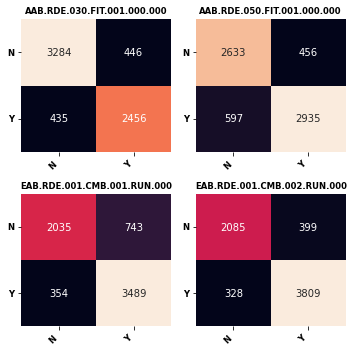

In [ ]:
# =========================== best model ====================================
best_model = Pipeline([('RFE',RFE(ctbml)),
                       ('CTB',ctbml)])
# =========================== ajust ====================================
y_dt_cls = y_dt.apply(lambda c: c.apply(lambda x: 1 if x>0.3 else 0))
y_stratify = [''.join(v) for i,v in y_dt_cls.astype(str).iterrows()]
# =========================== split ====================================
X_train, X_test,y_train, y_test = train_test_split(x_dt,y_dt_cls,stratify=y_stratify)
# =========================== train ====================================
best_model.fit(X_train, y_train)
# ========================== predict ===================================
y_hat = best_model.predict(X_test)

# ============================ confusion matrix ===================================
cm = multilabel_confusion_matrix(y_test, y_hat)
fig, ax = plt.subplots(2, 2, figsize=(5, 5))
for axes, cfs_matrix, label in zip(ax.flatten(), cm,df.columns):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
fig.tight_layout()
      
 # ============================ classifier reports ===================================
c_report = pd.DataFrame(classification_report(y_test, y_hat,output_dict=True))
display(c_report)

,0,1,2,3,micro avg,macro avg,weighted avg,samples avg
precision,0.856510,0.859171,0.843834,0.923244,0.872400,0.870690,0.872948,0.862936
recall,0.869249,0.856738,0.902680,0.924583,0.890995,0.888313,0.890995,0.871532
f1-score,0.862833,0.857953,0.872266,0.923913,0.881599,0.879241,0.881697,0.858276
support,2891.000000,3532.000000,3843.000000,4137.000000,14403.000000,14403.000000,14403.000000,14403.000000


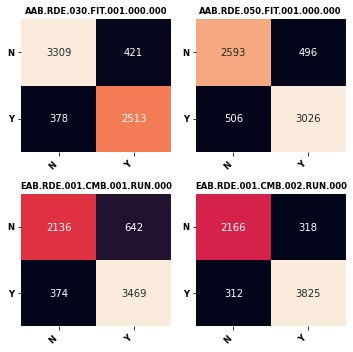

In [ ]:
from xgboost import XGBClassifier

lgbm = XGBClassifier(tree_method="approx")
# =========================== best model ====================================
best_model = Pipeline([('RFE',RFE(ctbml)),
                       ('CTB',lgbm)])
# =========================== ajust ====================================
y_dt_cls = y_dt.apply(lambda c: c.apply(lambda x: 1 if x>0.3 else 0))
y_stratify = [''.join(v) for i,v in y_dt_cls.astype(str).iterrows()]
# =========================== split ====================================
X_train, X_test,y_train, y_test = train_test_split(x_dt,y_dt_cls,stratify=y_stratify)
# =========================== train ====================================
lgbm.fit(X_train, y_train)
# ========================== predict ===================================
y_hat = lgbm.predict(X_test)

# ============================ confusion matrix ===================================
cm = multilabel_confusion_matrix(y_test, y_hat)
fig, ax = plt.subplots(2, 2, figsize=(5, 5))
for axes, cfs_matrix, label in zip(ax.flatten(), cm,df.columns):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
fig.tight_layout()
      
 # ============================ classifier reports ===================================
c_report = pd.DataFrame(classification_report(y_test, y_hat,output_dict=True))
display(c_report)

## **Classification arranje**

## **Regression logistic**